# Seismic Noise Attenuation

## Setup

In [1]:
# Setup dataset specifications. Specify model versions to run. These may affect the shapes of training datasets etc.
train_range = '0-137'
# numimg = 137
numchan = 1
version = f'6.0.il{train_range}'
load_versions = [version]
# load_versions = [f'5.4.il{train_range}', f'5.5.il{train_range}', f'5.6.il{train_range}']

In [2]:
# Force GPU usage where possible
gpu = 1                     
if gpu == 1:
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
elif gpu == 0:
    print("Running on CPU only")
    os.environ['CUDA_VISIBLE_DEVICES']='-1'

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Prepare Data

### Load and sort

In [3]:
import numpy as np 
# import segyio
import time
import matplotlib.pyplot as plt
# %matplotlib inline

In [4]:
# Read swell data and truncate to be evenly divisible by downsampling layers
import os
directory = '../Data/Swell/Train/'
file_names = os.listdir(directory)

input_data = []
output_data = []
for file_name in file_names:
    path = directory + file_name
    # print(f'Reading {path}')
    stream = np.load(path)
    slice_img = np.expand_dims(stream,0)
    raw_shape = np.array(slice_img.shape)
    # print(f'raw_shape {raw_shape}')
    slice_img_shape = raw_shape//4*4        # desired shape
    # slice_img_shape = np.array([1, 400, 592, 4])       # manual shape
    # print(f'slice_img_shape {slice_img_shape}')
    diff_shape = slice_img_shape-raw_shape   # mind first dimension if this input changes from 1 image
    # print(f'diff_shape {diff_shape}')
    
    
    if (diff_shape[1] != 0) & (diff_shape[2] != 0):
        slice_img = slice_img[:, :diff_shape[1], :diff_shape[2]]
    elif diff_shape[1] != 0:
        slice_img = slice_img[:, :diff_shape[1], :]
    elif diff_shape[2] != 0:
        slice_img = slice_img[:, :, :diff_shape[2]]
    else:
        print(f'Data truncation error on file: {file_name}')

    # print(f'File {file_name} fixed_shape {slice_img.shape}')
    
    if file_name.startswith("input"):
        input_data.append(slice_img)
    elif file_name.startswith("output"):
        output_data.append(slice_img)
    else:
        print(f"Unexpected file: {file_name}")

try:
    input_data = np.concatenate(input_data, axis=0 )
    output_data = np.concatenate(output_data, axis=0)
except ValueError as e:
    print("Varying input image dimensions not currently supported. Reshape images to fixed dimensions")
    
print(input_data.shape)
print(output_data.shape)

nil0 = 0

(138, 468, 592, 4)
(138, 468, 592, 4)


In [5]:
# Read Kerry3D
# # path = r"C:\Users\fmdel\OneDrive - University of Leeds\2021 Sem 1\HALLIBURTON\Data\Kerry3D.segy"
# path = '../Data/Kerry3D.segy'
# with segyio.open(path,iline=73, xline=21) as segyfile: # il/xl specify fields to look for in the trace headers. The numbers here are different to my old code but work...
#     data = segyio.tools.cube(segyfile)
#     size_mb= data.nbytes/1024**2
#     header = segyio.tools.wrap(segyfile.text[0])
    
# #     inlines = segyfile.ilines
# #     crosslines = segyfile.xlines
# #     twt = segyfile.samples + 1000
# #     sr = segyio.tools.dt(segyfile)

#     il, xl, t = segyfile.ilines, segyfile.xlines, segyfile.samples 
#     dt = t[1]-t[0] # don't bother with segyio.tools.dt(segyfile), it's in microseconds
    
# #     ntraces = segyfile.tracecount
# #     nsamples = segyfile.samples.size
#                             # These depend on how the data are slice_imgd, so I have commented them out until that stage
#     nil, nxl, nt = data.shape
#     ntr = segyfile.tracecount
#     nil0, nil1 = 510, 796 # Min/max iline numbers. different to il[0], il[-1] (some external coordinate system)
#     nxl0, nxl1 = 58, 792-3 # Min/max xline numbers. same as xl[0], xl[-1]. Added -3. Varying slice_img_dims not worth messing about with. keep manual
#     nt0, nt1 = 0, 5004 # Min/max twt. same as t[0], t[-1]
    
# import pickle
# with open('../Data/kerry_cube.pkl', 'wb') as file:
#     pickle.dump(data,file)
# print(f'data pickled')

# data = data[:,:-3,:]

In [6]:
# Load pickled kerry3d cube
# import pickle
# data = pickle.load(open('../Data/kerry_cube.pkl', 'rb'))
# data = data[:,:-3,:]

# nil0, nil1 = 510, 796 # Min/max iline numbers. different to il[0], il[-1] (some external coordinate system)
# nxl0, nxl1 = 58, 792-3 # Min/max xline numbers. same as xl[0], xl[-1]. Added -3. Varying slice_img_dims not worth messing about with. keep manual
# nt0, nt1 = 0, 5004 # Min/max twt. same as t[0], t[-1]
# nil, nxl, nt = data.shape  # shape AFTER slicing off 3 lines
# dt = 4.0

In [7]:
# load pickled DeepRift data
# import pickle
# with open('../Data/data_trunc.pkl', 'rb') as file:
#     data = pickle.load(file)
# nil0 = 0

# import os
# directory = '../Data/Mo_DeepRift_profiles/'
# file_names = os.listdir(directory)

##### [Debug]: View Data

In [10]:
# "Percentage of values lying outside of clip range"
# # num_std_clip = 20
# # xmax = num_std_clip*np.std(input_data[line_idx,:,:,chan])
# xmax = 1
# xmin = -xmax
# test = output_data.flatten()
# test[np.logical_or(test>=xmax,test<=xmin)].shape[0]/test.shape[0]*100

3.046015418637701

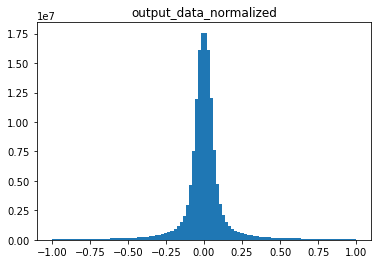

In [11]:
# plt.hist(output_data.flatten(), bins=100, range=(-1,1))
# plt.title('output_data_normalized')
# plt.show()

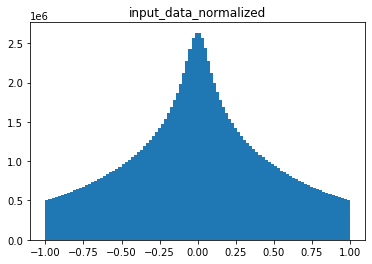

In [12]:
# plt.hist(input_data.flatten(), bins=100, range=(-1,1))
# plt.title('input_data_normalized')
# plt.show()

In [13]:
# image = input_data[idx_end, :, :, chan] # want to keep timeseries as rows for fft, don't transpose
# ps = np.average(np.abs(np.fft.fft(image)), axis=0)
# freqs = np.fft.fftfreq(ps.size, 2*10**-3)
# idx = np.argsort(freqs)
# idx = idx[len(idx)//2:]
# plt.plot(freqs[idx], ps[idx])
# plt.title('raw input image power spectrum (assumed sampling)')
# plt.show()

NameError: name 'idx_end' is not defined

In [ ]:
# "Percentage of values lying outside of clip range"
# num_std_clip = 8
# # xmax = num_std_clip*np.std(input_data[line_idx,:,:,chan])
# test = input_data.flatten()
# xmax = num_std_clip*np.std(test)
# xmin = -xmax
# test[np.logical_or(test>=xmax,test<=xmin)].shape[0]/test.shape[0]*100

In [ ]:
# # View a single line to verify
# line_idx = 137 # line to view
# chan = 0
# print(f'line number: {line_idx+nil0}')

# num_std_clip = 4
# gain = 4
# cbar_scale = 1/gain
# xmax = num_std_clip*np.std(input_data[line_idx,:,:,chan])
# # xmax = num_std_clip*np.std(data[line_idx,:,:]) # note np.std(slice_img) changes value slightly from previous line
# xmin = -xmax
# # plotdata = np.clip(data[line_idx,:,:], 

# plt.figure(figsize=(12, 8))
# # plt.imshow(data[line_idx,:,:].T, aspect='auto', cmap='RdYlBu', vmin=-5, vmax=5)
# plt.imshow(input_data[line_idx,:,:,chan].T, aspect='auto', cmap='RdYlBu',
#            # vmin=xmin*cbar_scale, vmax=xmax*cbar_scale
#           )
# # plt.imshow(data[line_idx,:,:].T, aspect='auto', cmap='RdYlBu', vmin=xmin*cbar_scale, vmax=xmax*cbar_scale)
# plt.colorbar()
# plt.gray()
# plt.tight_layout()

### Define Functions for Train & Test Sets

In [ ]:
import random
    
def prepdata(data, scale_range, num_std_clip, numimg, numchan, i_start, noise_factor):
    """Minmax scaling, optional gaussian noise"""
    # np.random.seed(999)
    noise_seeds = np.random.choice(range(0,10000),1000, False)

    dataset = np.empty(shape=(numimg//numchan, data.shape[1], data.shape[2], numchan))
    i = i_start
    while i < numimg + i_start:
        slice_img = data[i,:,:]
        slice_img = slice_img - np.mean(slice_img)
        # slice_img = slice_img + noise_factor*np.random.normal(loc=0.0, scale=np.std(slice_img), size=slice_img.shape)  # noise
        xmax = num_std_clip*np.std(slice_img) # note np.std(slice_img) changes value slightly from previous line
        xmin = -xmax

        slice_img = scale_range[0]+((slice_img-xmin)*(scale_range[1]-scale_range[0]))/(xmax - xmin)
             
        if noise_factor != 0:
            np.random.seed(noise_seeds[i])
            slice_img = slice_img + noise_factor*np.random.normal(loc=0.0, scale=np.std(slice_img), size=slice_img.shape)  # noise

        dataset[(i-i_start)//numchan, :, :, (i-i_start)%numchan] = slice_img
        # print(i)
        # print(f"{(i-i_start)//numchan}, :, :, {(i-i_start)%numchan}")   
        i += 1
    # i_start_test = i
    dataset = dataset.astype('float32')
    return(dataset, i)

In [10]:
import random
# import cv2

def num_elements(array):
    size = 1
    for dim in np.shape(array):
        size *= dim
    return size

# def saltpepper(array, max_factor_pixels_corrupted, scale_range):
#     """Replace random number of pixels (up to a cutoff) with salt and pepper"""
#     # noise_seeds = np.random.choice(range(0,10000),1000, False)
#     total_pixels = num_elements(array)
#     num_pixles_corrupted = np.random.randint(low=0, high=total_pixels*max_factor_pixels_corrupted)
#     pixel_idx = np.random.choice(range(0,total_pixels-1), num_pixles_corrupted, False)
#     black_idx = pixel_idx[:len(pixel_idx)//2]
#     white_idx = pixel_idx[len(pixel_idx)//2:len(pixel_idx)//2*2]
#     array_corrupted = array.flatten()
#     for i in black_idx:
#         array_corrupted[i] = scale_range[0]
#     for i in white_idx:
#         array_corrupted[i] = scale_range[1]    
#     array_corrupted = array_corrupted.reshape(array.shape).astype('float32')
    
#     return(array_corrupted)

In [11]:
# from tensorflow.keras.utils import Sequence

# class sp_generator(Sequence):
#     """Generates randomized salt and peppered input images, Keras-style"""
    
#     def __init__(self, array, to_fit, numchan=1, batch_size=1):
#         self.array = array
#         self.to_fit = to_fit
#         self.numchan = numchan
#         self.batch_size = batch_size
#         # self.shuffle = shuffle # needs to be in the init params if used # shouldn't make a difference, not using batches
#         self.on_epoch_end() #
#         self.indexes = np.arange(len(self.array))
        
#     def __len__(self):
#         """Batches per epoch"""
#         return int(np.floor(len(self.array))) # first dimension of data needs to be image idx but it should already be

#     def __getitem__(self, index):
#         """Generate one batch of data
#         :param index: index of the batch"""
#         indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         x = saltpepper(self.array[index], factor_pixels_corrupted, scale_range)
#         if self.to_fit:
#             y = self.array
#             return x, y
#         else:
#             return x
        
#     def on_epoch_end(self):
#         # self.indexes = np.arange(len(self.array)) # randomize order of images within a batch
#         # if self.shuffle == True:
#         #     np.random.shuffle(self.indexes)
#         pass

In [12]:

# def sp_generator_sat(array,  factor_pixels_corrupted, scale_range, steps_per_epoch, numchan, batch_size):
#     "Do the same thing but as a function"
#     epochn = initial_epoch
#     counter = 0
#     while True:
#         for batch in range(batch_size):
#             counter += 1
#             x = saltpepper(array[counter-1], factor_pixels_corrupted, scale_range)
#             y = array
#             if counter ==(steps_per_epoch):
#                 epochn += 1
#                 counter=0
#         yield x, y
        
# def sp_input_sat(array,  factor_pixels_corrupted, scale_range, steps_per_epoch, numchan, batch_size):
#     dataset = tf.Dataset.from_generator(lambda: sp_generator_sat(array,  factor_pixels_corrupted, scale_range, steps_per_epoch, numchan, batch_size),
#                                         output_types=(tf.float32, tf.float32),
#                                        )
#     dataset = dataset.batch(1)
#     return(dataset)

In [13]:
# swell dataset comes pre-arranged into clean-noisy pairs. No additional noise from above cells required
def swell_generator(x_array, y_array):
    # epoch = initial_epoch
    indexes = np.arange(len(x_array))
    # counter = 0
    while True:
        # counter += 1
        index = np.random.choice(indexes)
        x = x_array[index,:,:,:]
        y = y_array[index,:,:,:]
        # if counter ==(steps_per_epoch):
        #         epochn += 1
        #         counter=0
        yield x, y
    
def swell_input(x_array, y_array):
    dataset = tf.data.Dataset.from_generator(lambda: swell_generator(x_array, y_array), output_types=(tf.float32, tf.float32))
    dataset = dataset.batch(1)
    return dataset

### Pre-Generate Train/Test Sets

If a generator is used in the training, these simply call the functions above required to minmax scale and segment the "clean" data.

In [14]:
"""Minmax scale train dataset Satdat (Version 5)"""
num_std_clip = 8
scale_range = [-1,1]

# input_data_scaled = np.empty(input_data.shape)
# for i in range(input_data.shape[0]):
#     for l in range(input_data.shape[-1]):
#         slice_img = input_data[i,:,:,l]
#         slice_img = slice_img - np.mean(slice_img)
#         xmax = num_std_clip*np.std(slice_img) # note np.std(slice_img) changes value slightly from previous line
#         xmin = -xmax
#         slice_img = scale_range[0]+((slice_img-xmin)*(scale_range[1]-scale_range[0]))/(xmax - xmin)
#         input_data_scaled[i,:,:,l] = slice_img
        
# output_data_scaled = np.empty(input_data.shape)
# for i in range(output_data.shape[0]):
#     for l in range(output_data.shape[-1]):
#         slice_img = output_data[i,:,:,l]
#         slice_img = slice_img - np.mean(slice_img)
#         xmax = num_std_clip*np.std(slice_img) # note np.std(slice_img) changes value slightly from previous line
#         xmin = -xmax
#         slice_img = scale_range[0]+((slice_img-xmin)*(scale_range[1]-scale_range[0]))/(xmax - xmin)
#         output_data_scaled[i,:,:,l] = slice_img

# input_data = input_data_scaled
# input_data_scaled = None

# output_data = output_data_scaled
# output_data_scaled = None

In [15]:
"""optional to reshape to 1 channel input"""
input_data1 = np.reshape(input_data.transpose(0,3,1,2), input_data.shape[:3]*np.array([4,1,1]), order='C')
input_data1 = np.expand_dims(input_data1, axis=3)

output_data1 = np.reshape(output_data.transpose(0,3,1,2), output_data.shape[:3]*np.array([4,1,1]), order='C')
output_data1 = np.expand_dims(output_data1, axis=3)

input_data1 = input_data1[:-3,:,:,:]
output_data1 = output_data1[:-3,:,:,:]

# 4 channel input not renamed

"""Generate train/test datasets Satdat (Version 5)""" # 4 channel input with no "1" suffix
# x_train = input_data[:-1,:,:,:]
x_train = output_data[:-1,:,:,:]
y_train = output_data[:-1,:,:,:]
# x_train1 = input_data1[:-1,:,:,:]
x_train1 = output_data1[:-1,:,:,:]
y_train1 = output_data1[:-1,:,:,:]

# x_test = input_data[-1,:,:,:] 
x_test = output_data[-1,:,:,:]
y_test = output_data[-1,:,:,:]
# x_test1 = input_data1[-1,:,:,:]
x_test1 = output_data1[-1,:,:,:]
y_test1 = output_data1[-1,:,:,:]

x_test = np.expand_dims(x_test, axis=0)
y_test = np.expand_dims(y_test, axis=0)
x_test1 = np.expand_dims(x_test1, axis=0)
y_test1 = np.expand_dims(y_test1, axis=0)

In [83]:
   # to ensure exactly the same image is predicted

In [104]:
print(x_test.shape, y_test.shape, x_test1.shape, y_test1.shape)

(1, 468, 592, 4) (1, 468, 592, 4) (1, 468, 592, 1) (1, 468, 592, 1)


In [ ]:
# """Generate train/test datasets Kerry3D (Version 1)"""
# # scale_range, num_std_clip, numimg, numchan, i_start, noise_factor
# # x_test, idx_end = prepdata(data, [-1,1], 4, training_range[1]-training_range[0]+1, 1, 0, 0)  # DeepRift

# x_train, idx_end = prepdata(data, [-1,1], 4, numimg, 4, 1, 0)  # kerry3d (1.7-1.9)
# x_train_noisy, _ = prepdata(data, [-1,1], 4, numimg, 4, 1, 1)  # kerry3d (1.10)

# x_test, _ = prepdata(data, [-1,1], 4, 8, 4, idx_end, 0)  # kerry3d (1.7-1.9)
# x_test_noisy, _ = prepdata(data, [-1,1], 4, 8, 4, idx_end, 1)  # kerry3d (1.10)

In [ ]:
# """Generate train/test datasets Deeprift (Version 2)"""
# x_train, idx_end = prepdata(data, [-1,1], 4, numimg, 1, 0, 0)  # DeepRift (2.1-2.4)
# x_train_noisy, _ = prepdata(data, [-1,1], 4, numimg, 1, 0, 1)  # DeepRift (2.1-2.4)

# # x_test, _ = prepdata(data, [-1,1], 4, 4, 1, idx_end, 0)  # DeepRift (2.1-2.4)    # changed to 1 test image for gif
# # x_test_noisy, _ = prepdata(data, [-1,1], 4, 4, 1, idx_end, 1)  # DeepRift (2.1-2.4)
# x_test, _ = prepdata(data, [-1,1], 4, 8, 1, idx_end, 0)  # DeepRift (2.1-2.4)    # changed to 8 test images
# x_test_noisy, _ = prepdata(data, [-1,1], 4, 8, 1, idx_end, 1)  # DeepRift (2.1-2.4)

In [ ]:
# """Generate single image DeepRift (Version 4)"""
# scale_ranges = [[-1,1]]
# scale_range = scale_ranges[0]
# x_train, _ = prepdata(data, [-1,1], 4, numimg, 1, 70, 0)  # DeepRift (2.1-2.4)
# idx_end = 0
# # x_train_noisy, _ = saltpepper(x_train, )  # DeepRift (2.1-2.4)

# x_test = x_train
# x_tests = [x_test]
# # x_test_noisy, _ = prepdata(data, [-1,1], 4, 4, 1, idx_end, 1)  # DeepRift (2.1-2.4)

# data = np.empty(data.shape)

In [ ]:
# scale_ranges = [[-1,1], [-1,1], [-1,1], [-1,1]]
# # x_tests = [x_test_noisy, x_test_noisy, x_test_noisy, x_test_noisy]
# x_tests = [x_test, x_test, x_test, x_test]
# x_test.shape

In [ ]:
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train_noisy = x_train_noisy.astype('float32')
# x_test_noisy = x_test_noisy.astype('float32')
# print(f'Training set shape: {np.shape(x_train)}')
# print(f'Testing set shape: {np.shape(x_test)}')

#### [Debug]: Verify with plots

In [ ]:
# i=64

# slice_img = data[i,:,:]
# slice_img = slice_img - np.mean(slice_img)
# # slice_img = slice_img + noise_factor*np.random.normal(loc=0.0, scale=np.std(slice_img), size=slice_img.shape)  # noise
# xmax = 4*np.std(slice_img) # note np.std(slice_img) changes value slightly from previous line
# xmin = -xmax

# slice_img = scale_range[0]+((slice_img-xmin)*(scale_range[1]-scale_range[0]))/(xmax - xmin)
# plt.imshow(slice_img[:,:].T, aspect='auto', vmin=-0.1, vmax=0.1)
# plt.colorbar()

In [ ]:
# gain = 100
# cbar_scale = 1/gain

# fig, axes = plt.subplots(4,2, figsize=(12, 8))

# for i in range(x_test.shape[0]):
#     plt.subplot(4,2,i+1)
#     plt.imshow(x_test[i,:,:,0].T,
#                cmap='RdYlBu', 
#                vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale
#               )
#     plt.gray()
#     plt.colorbar()
#     plt.axis('tight')
#     plt.title(epochs[i])


# # plt.imshow(x_train[0,:,:,0].T, aspect='auto', cmap='RdYlBu', vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale)
# # plt.colorbar()
# # plt.gray()
# # plt.tight_layout()
# # plt.title(f'{file_names[line_num]} normalized to {scale_range}, gain of {gain}') 
# # plt.savefig(f'DeepRift_{line_num}_norm_resize')
# plt.savefig('test')

In [ ]:
# line_num = 10 # line to view
# gain = 5
# cbar_scale = 1/gain
# scale_range = scale_ranges[0]

# plt.figure(figsize=(12, 8))
# plt.imshow(x_train[line_num,:,:,0].T, aspect='auto', cmap='RdYlBu', vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale)
# plt.colorbar()
# plt.gray()
# plt.tight_layout()

# # plt.figure(figsize=(12, 8))
# # plt.imshow(all_clean_images[2][19,line_num,:,:,0].T, aspect='auto', cmap='RdYlBu', vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale)
# # plt.colorbar()
# # plt.gray()
# # plt.tight_layout()


In [ ]:
# line_num = 0 # line to view
# gain = 5
# cbar_scale = 1/gain

# plt.figure(figsize=(12, 8))
# plt.imshow(x_train[line_num,:,:,0].T, aspect='auto', cmap='RdYlBu', vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale)
# plt.colorbar()
# plt.gray()
# plt.tight_layout()
# plt.title(f'{file_names[line_num]} normalized to {scale_range}, gain of {gain}') 
# plt.savefig(f'DeepRift_{line_num}_norm_resize')

# Build Model

In [38]:
# input_data = None
data = np.empty(x_test.shape)

In [39]:
# # if model did not reach savepoint: generate architecture
import os
import keras
import tensorflow as tf
from keras import layers

tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float32')


input_img = keras.Input(shape=(data.shape[1], data.shape[2], numchan))                            # put shape = none ?
act= tf.keras.layers.LeakyReLU()                                         # default 0.3 negative slope throughout. Consider changing???
conv1 = layers.Conv2D(64, (3,3), activation=act, padding='same', name='conv1')(input_img)    # conv
enc1 = layers.Conv2D(32, (3,3), strides=(2,2), padding='same', name='enc1')(conv1)           # informed downsampling
conv2 = layers.Conv2D(32, (3,3), activation=act, padding='same', name='conv2')(enc1)         # conv
enc2 = layers.Conv2D(32, (3,3), strides=(2,2), padding='same', name='enc2')(conv2)      # informed downsampling

conv3 = layers.Conv2D(32, (3,3), activation=act, padding='same', name='bottleneck')(enc2)   # latent space
dec1 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), activation=act, padding='valid', name='dec1')(conv3) # informed upsampling
skip1 = layers.Concatenate()([dec1, conv2]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! be sure to check architecture before training
conv4 = layers.Conv2D(32, (3,3), activation=act, padding='same', name='conv4')(skip1) # conv
dec2 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), activation=act, padding='valid', name='dec2')(conv4) # informed upsampling
# skip2 = layers.Concatenate()([dec2, conv1]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! be sure to check architecture before training
conv5 = layers.Conv2D(64, (3,3), activation=act, padding='same', name='conv5')(dec2) # conv

output = layers.Conv2D(numchan, (3, 3), activation='linear', padding='same')(conv5)

Unet = keras.Model(input_img, output)
Unet.compile(optimizer='adam', loss='mse', metrics=['mae']) # The quantity to be monitored for early stopping needs to be available in logs dict. To make it so, pass the loss or metrics here

loaded_model = Unet
Unet = None
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 468, 592, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 468, 592, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
enc1 (Conv2D)                   (None, 234, 296, 32) 18464       conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 234, 296, 32) 9248        enc1[0][0]                       
______________________________________________________________________________________________

# Prepare Checkpoints

In [62]:
os.makedirs('Logs', exist_ok=True)
# os.makedirs(f'./Logs/{version}', exist_ok=True)  # was a bit silly to do the folders this way, but ah well. Should probably make an info file each run. For now keep changelog
os.makedirs(f'./Logs/checkpoints_{version}', exist_ok=True)
os.makedirs(f'./Logs/TBlog_{version}', exist_ok=True)
# os.makedirs(f'./Logs/csvlog_{version}', exist_ok=True)

# ckpt_filepath = './Logs/checkpoints_{}/ckpt-{epoch:02d}.hdf5'.format(version)
pathstart = './Logs/checkpoints_{}/'.format(version)
pathend = 'ckpt-{epoch:02d}.hdf5'
ckpt_filepath = pathstart + pathend

# checkpoint_filepath = f'C:\Python\Python39\Scripts\modelCheckpoints\checkpoints_{version}' # is there any reason not to move this somewhere more consistent with the rest??? Need to email Mryga about checkpoints.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    # filepath='./Logs/checkpoints_1.7.il511-650/ckpt-{epoch:02d}.hdf5',
    filepath = ckpt_filepath,
    # save_weights_only=False,
    save_weights_only=True,
    monitor=('loss'),
    mode='max',
    save_freq='epoch',
    verbose=1,
    # period=10 # deprecated for some reason
    save_best_only=False, # want to save full model every x epochs to print image
)

tensor_board_callback = tf.keras.callbacks.TensorBoard(log_dir=f'./Logs/TBlog_{version}', write_graph=True, write_images=True)
csvlogger_callback = tf.keras.callbacks.CSVLogger(f'./Logs/csvlog_{version}.csv', separator=',', append=False) # keeps record of weights
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Model Training

In [ ]:
# Train on 4 channel swell data input/output
"""5.0"""
# import pydot
# import pydotplus
# tf.keras.utils.plot_model(loaded_model, show_shapes=True, show_layer_names=True)
# tf.keras.utils.plot_model(loaded_model, to_file= f'./{version}_arch.png', show_shapes=True, show_layer_names=True)

initial_epoch = 1

callbacks=[model_checkpoint_callback,
           tensor_board_callback,
           csvlogger_callback,
           # early_stopping_callback,
          ]

import keras
tf.keras.backend.clear_session()
# reset_keras()
start_time = time.time()
try:
    history=loaded_model.fit(
                    # x=x_train, y=y_train, # update saltpepper to output x_train, get rid of y
                    swell_input(x_train, y_train),
                    steps_per_epoch = x_train.shape[0],
                    validation_data=(x_test, y_test),
                    epochs=20000,
                    callbacks=callbacks,        
                    use_multiprocessing=True, # Note using this makes keras expect a generator
                    # workers=8,
                            )
                            
# try:
#     history=loaded_model.fit_generator(generator=training_generator,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=8,
#                     epochs=1000,
#                     callbacks=callbacks)
except KeyboardInterrupt:
    tf.keras.backend.clear_session()

end_time = time.time()
elapsed_time = end_time-start_time
print(f'Elapsed time: {elapsed_time}')

In [64]:
# """single image for DIP"""
# import pydot
# import pydotplus
# tf.keras.utils.plot_model(loaded_model, show_shapes=True, show_layer_names=True)
# tf.keras.utils.plot_model(loaded_model, to_file= f'./{version}_arch.png', show_shapes=True, show_layer_names=True)

# model_idx=0
# max_factor_pixels_corrupted = 0.1
# scale_range = scale_ranges[model_idx]

# callbacks=[model_checkpoint_callback,
#            tensor_board_callback,
#            csvlogger_callback,
#            # early_stopping_callback,
#           ]

# import keras
# tf.keras.backend.clear_session()
# # reset_keras()
# start_time = time.time()
# try:
#     history=loaded_model.fit(x=y_test1, y=y_test1, # update saltpepper to output x_train, get rid of y
#                     validation_data=(y_test1, y_test1),
#                     epochs=1000,
#                     callbacks=callbacks,        
#                     use_multiprocessing=True,
#                     # workers=8,
#                             )
                            
# # try:
# #     history=loaded_model.fit_generator(generator=training_generator,
# #                     validation_data=validation_generator,
# #                     use_multiprocessing=True,
# #                     workers=8,
# #                     epochs=1000,
# #                     callbacks=callbacks)
# except KeyboardInterrupt:
#     tf.keras.backend.clear_session()

# end_time = time.time()
# elapsed_time = end_time-start_time
# print(f'Elapsed time: {elapsed_time}')

Epoch 1/1000
1/1 [==============================] - 0s 429ms/step - loss: 0.0056 - mae: 0.0468 - val_loss: 0.0055 - val_mae: 0.0463

Epoch 00001: saving model to ./Logs/checkpoints_6.0.il0-137\ckpt-01.hdf5
Epoch 2/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0055 - mae: 0.0463 - val_loss: 0.0054 - val_mae: 0.0459

Epoch 00002: saving model to ./Logs/checkpoints_6.0.il0-137\ckpt-02.hdf5
Epoch 3/1000
1/1 [==============================] - 0s 121ms/step - loss: 0.0054 - mae: 0.0459 - val_loss: 0.0054 - val_mae: 0.0455

Epoch 00003: saving model to ./Logs/checkpoints_6.0.il0-137\ckpt-03.hdf5
Epoch 4/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.0054 - mae: 0.0455 - val_loss: 0.0053 - val_mae: 0.0451

Epoch 00004: saving model to ./Logs/checkpoints_6.0.il0-137\ckpt-04.hdf5
Epoch 5/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.0053 - mae: 0.0451 - val_loss: 0.0052 - val_mae: 0.0447

Epoch 00005: saving model to ./Logs/checkpoint

In [ ]:
# """Just calls saltpepper function to prep a single image for DIP"""
# import pydot
# import pydotplus
# tf.keras.utils.plot_model(loaded_model, show_shapes=True, show_layer_names=True)
# tf.keras.utils.plot_model(loaded_model, to_file= f'./{version}_arch.png', show_shapes=True, show_layer_names=True)

# model_idx=0
# max_factor_pixels_corrupted = 0.1
# scale_range = scale_ranges[model_idx]
# x_test = x_tests[model_idx]

# callbacks=[model_checkpoint_callback,
#            tensor_board_callback,
#            csvlogger_callback,
#            # early_stopping_callback,
#           ]

# import keras
# tf.keras.backend.clear_session()
# # reset_keras()
# start_time = time.time()
# try:
#     history=loaded_model.fit(x=saltpepper(x_train, max_factor_pixels_corrupted, scale_range), y=x_train, # update saltpepper to output x_train, get rid of y
#                     validation_data=(saltpepper(x_train, max_factor_pixels_corrupted, scale_range), x_test),
#                     epochs=1000,
#                     callbacks=callbacks,        
#                     use_multiprocessing=True,
#                     # workers=8,
#                             )
                            
# # try:
# #     history=loaded_model.fit_generator(generator=training_generator,
# #                     validation_data=validation_generator,
# #                     use_multiprocessing=True,
# #                     workers=8,
# #                     epochs=1000,
# #                     callbacks=callbacks)
# except KeyboardInterrupt:
#     tf.keras.backend.clear_session()

# end_time = time.time()
# elapsed_time = end_time-start_time
# print(f'Elapsed time: {elapsed_time}')

### Save

In [40]:
# from keras.models import model_from_json
Unet_json = loaded_model.to_json()         # save architecture
with open(f"Unet_{version}.json", "w") as json_file:
    json_file.write(Unet_json)
# serialize weights to HDF5
# loaded_model.save_weights(f"Unet_{version}.h5")       # save weights
print("Saved model to disk")

Saved model to disk


## Call Saved Model

### Loss

In [16]:
# load loss
import pandas as pd
loss_dfs = []
for load_version in load_versions:
    loss_df = pd.DataFrame(pd.read_csv(f'./Logs/csvlog_{load_version}.csv'))
    loss_df.set_index('epoch')
    loss_dfs.append(loss_df)

In [17]:
load_versions

['6.0.il0-137']

In [18]:
# Manually specify descriptions of load versions (in the same order) for easier plot labelling later
# descriptions = ['L2, no skip', 'L2, bottom skip', 'L2, both skip', 'L2, bottom skip, syn noise']
# descriptions = ['L2, no skip', 'L2, bottom skip', 'L1, bottom skip', 'L1, both skip']
# descriptions = ['L1, bottom skip']
descriptions = ['6.0 L2, bottom skip']

In [ ]:
# plt.rcParams.update(plt.rcParamsDefault)
# fig, axes = plt.subplots(2,2, figsize=(8,8))
# for i in range(len(load_versions)):
#     loss_df = loss_dfs[i]
#     ax = axes.flatten()[i]
#     ax.plot(loss_df['loss'])
#     # ax.plot(loss_df['val_loss'])
#     ax.set_ylabel('loss')
#     ax.set_xlabel('epoch')
#     # ax.legend(['train', 'test'], loc='upper left')
#     # ax.set_title(load_versions[i][0:4])
#     ax.set_xlim(-10,310)
#     ax.set_title(load_versions[i][0:4] + ': ' + descriptions[i])
#     ax.ticklabel_format(useOffset=False, style='plain')

# fig.tight_layout()
# plt.suptitle('Kerry3D loss', y=1.02)
# plt.show()
# # plt.savefig(

In [20]:
"""duplicates loss column to a new column with appropriate metric title for easier plotting"""
loss_dfs[0]['mse'] = loss_dfs[0].loc[:,'loss']
loss_dfs[0]['val_mse'] = loss_dfs[0].loc[:,'val_loss']


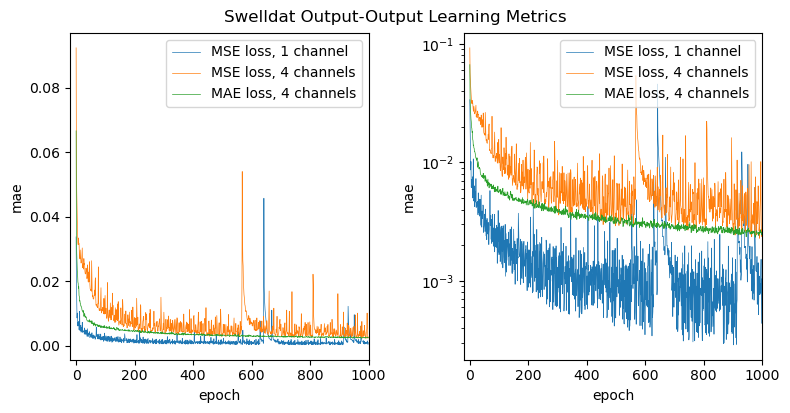

In [27]:
"""Plot losses on same plot with legend"""
# x_lim = (-10, 310)
max_x_lim = 1000
x_lim = (-max_x_lim/50, max_x_lim)
# x_lim=(-50, 1050)
loss_tag = 'mae'

plt.rcParams.update(plt.rcParamsDefault)
fig, axes = plt.subplots(1,2, figsize=(8,4))
for i in range(len(load_versions)):
    loss_df = loss_dfs[i]
    ax = axes.flatten()[0]
    ax.plot(loss_df[loss_tag], linewidth=0.5)
    # ax.plot(loss_df['val_loss'])
    ax.set_ylabel(loss_tag)
    ax.set_xlabel('epoch')
    ax.legend(descriptions)
    # ax.set_title('loss')

    ax.set_xlim(x_lim)
    ax.legend(descriptions, loc='upper right')

    # ax.set_title(load_versions[i][0:4] + ': ' + descriptions[i])
    # ax.ticklabel_format(useOffset=False, style='plain')
    
    ax = axes.flatten()[-1]
    ax.plot(loss_df[loss_tag], linewidth=0.5)
    # ax.plot(loss_df['val_loss'])
    ax.set_yscale('log')
    ax.set_ylabel(loss_tag)
    ax.set_xlabel('epoch')
    
    ax.set_xlim(x_lim)
    ax.legend(descriptions, loc='upper right')
    # ax.set_title('log loss')

# ax.legend([str(load_versions[0][0:3])])
    
fig.tight_layout()
plt.suptitle('stripedatdat Output-Output Learning Metrics', y=1.02)
plt.show()

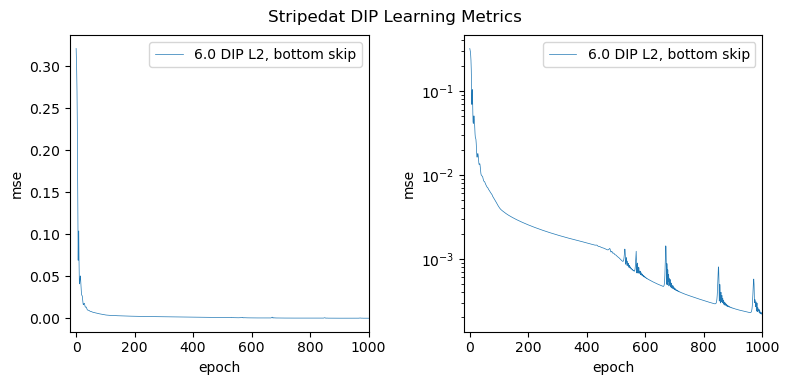

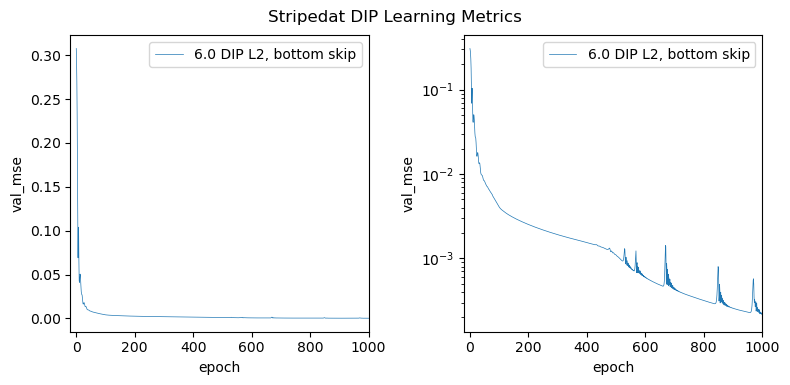

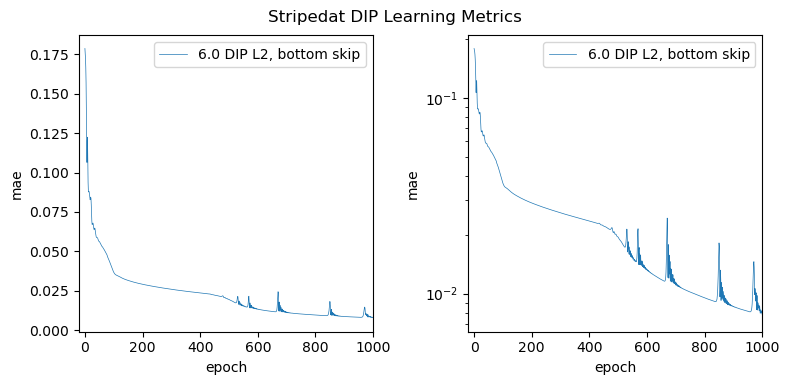

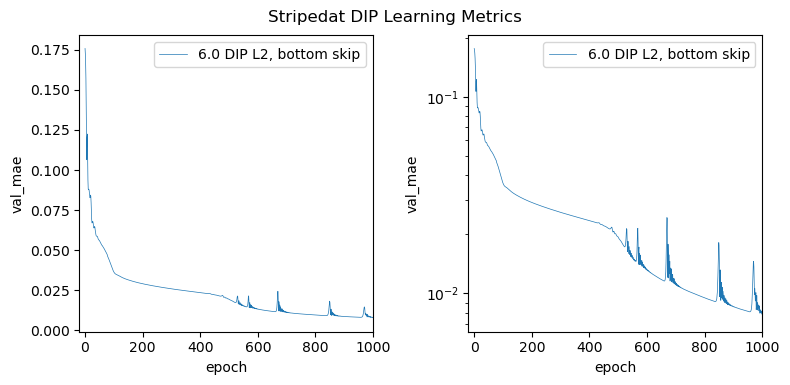

In [22]:
"""Plot additional metrics on same plot with legend"""
# x_lim = (-10, 310)
max_x_lim = 1000
max_y_lim = 0.05
x_lim = (-max_x_lim/50, max_x_lim)
y_lim = (-max_y_lim/50, max_y_lim)
# x_lim=(-50, 1050)
loss_tags = ['mse', 'val_mse', 'mae', 'val_mae']

for loss_tag in loss_tags:

    plt.rcParams.update(plt.rcParamsDefault)
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    for i in range(len(load_versions)):
        loss_df = loss_dfs[i]
        ax = axes.flatten()[0]
        ax.plot(loss_df[loss_tag], linewidth=0.5)
        # ax.plot(loss_df['val_loss'])
        ax.set_ylabel(loss_tag)
        ax.set_xlabel('epoch')
        ax.legend(descriptions)
        # ax.set_title('loss')

        # ax.set_ylim(y_lim)
        ax.set_xlim(x_lim)
        ax.legend(descriptions, loc='upper right')

        # ax.set_title(load_versions[i][0:4] + ': ' + descriptions[i])
        # ax.ticklabel_format(useOffset=False, style='plain')

        ax = axes.flatten()[-1]
        ax.plot(loss_df[loss_tag], linewidth=0.5)
        # ax.plot(loss_df['val_loss'])
        ax.set_yscale('log')
        ax.set_ylabel(loss_tag)
        ax.set_xlabel('epoch')

        ax.set_xlim(x_lim)
        ax.legend(descriptions, loc='upper right')
        # ax.set_title('log loss')

    # ax.legend([str(load_versions[0][0:3])])

    plt.suptitle('Stripedat DIP Learning Metrics', y=.95) # y=1.02
    fig.tight_layout()

    plt.savefig(f'SNA_Unet_6.0_{loss_tag}_loss.png')
    plt.show()


In [ ]:
# i=0
# fig, ax = plt.subplots(1,1, figsize=(4,4))
# loss_df = loss_dfs[i]
# ax.plot(loss_df['loss'])
# # ax.plot(loss_df['val_loss'])
# # ax.set_yscale('log')
# ax.set_ylabel('loss')
# ax.set_xlabel('epoch')
# ax.set_xlim(-10,310)
# ax.set_title(load_versions[i][0:4] + ': ' + descriptions[i])
# fig.tight_layout()

# plt.suptitle('Mo DeepRift L1 loss', y=1.02)
# plt.show()


In [ ]:
# plt.rcParams.update(plt.rcParamsDefault)
# fig, axes = plt.subplots(2,2, figsize=(8,8))
# for i in range(len(load_versions)):
#     loss_df = loss_dfs[i]
#     ax = axes.flatten()[i]
#     ax.plot(loss_df['loss'])
#     # ax.plot(loss_df['val_loss'])
#     ax.set_yscale('log')
#     ax.set_ylabel('loss')
#     ax.set_xlabel('epoch')
#     # ax.legend(['train', 'test'], loc='upper left')
#     # ax.set_title(load_versions[i][0:4])
#     ax.set_xlim(-10,310)
#     ax.set_title(load_versions[i][0:4] + ': ' + descriptions[i])
#     # ax.ticklabel_format(useOffset=False, style='plain')

# fig.tight_layout()
# plt.suptitle('Kerry3D log loss', y=1.02)
# plt.show()

In [ ]:
# plt.rcParams.update(plt.rcParamsDefault)
# fig, ax = plt.subplots(figsize=(4,4))
# legend = []
# for i in range(len(load_versions)):
#     loss_df = loss_dfs[i]
#     ax.plot(loss_df['loss'], linewidth=1)
#     # ax.plot(loss_df['val_loss'])
#     ax.set_yscale('log')
#     ax.set_ylabel('loss')
#     ax.set_xlabel('epoch')
#     # ax.legend(['train', 'test'], loc='upper left')
    
#     # ax.set_title(load_versions[i][0:4])
#     ax.set_xlim(-10,1010)
#     ax.set_ylim(10**-7,10**-1)
#     # ax.set_title(load_versions[i][0:4] + ': ' + descriptions[i])
#     # ax.ticklabel_format(useOffset=False, style='plain')
#     legend.append((load_versions[i][0:4]))
# ax.legend(legend)
# fig.tight_layout()
# # plt.suptitle('Kerry3D log loss', y=1.02)
# plt.title('Kerry3D log loss')
# plt.show()

## Model

In [23]:
import keras
from keras.models import model_from_json

def load_model(load_version):
    i = np.where(np.array(load_versions)==load_version)[0][0]
    json_file = open(f'Unet_{load_version}.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()                         
    loaded_model = model_from_json(loaded_model_json)  
    print(f'Loaded {load_version}')
    return loaded_model

In [24]:
# for an older dataset
    # if load_versions[i] == '2.1.il0-63':
    #     loaded_model.compile(optimizer='adam', loss='mse', metrics = ['mean_absolute_error'])
    # elif load_versions[i] == '2.3.il0-63':
    #     loaded_model.compile(optimizer='adam', loss='mse', metrics = ['mean_absolute_error'])
    # elif load_versions[i] == '2.2.il0-63':
    #     loaded_model.compile(optimizer='adam', loss='mae', metrics = ['mean_squared_error'])
    # elif load_versions[i] == '2.4.il0-63':
    #     loaded_model.compile(optimizer='adam', loss='mae', metrics = ['mean_squared_error'])


In [26]:
# for an older dataset
# loaded_models[0].compile(optimizer='adam', loss='mse', metrics = ['mean_absolute_error'])
# loaded_models[1].compile(optimizer='adam', loss='mse', metrics = ['mean_absolute_error'])
# loaded_models[2].compile(optimizer='adam', loss='mae', metrics = ['mean_squared_error'])
# loaded_models[3].compile(optimizer='adam', loss='mae', metrics = ['mean_squared_error'])

In [ ]:
# # set up to re-train a loaded model / architecture if you so wish
# version = load_version

# pathstart = './Logs/checkpoints_{}/'.format(version)
# pathend = 'ckpt-{epoch:02d}.hdf5'
# ckpt_filepath = pathstart + pathend

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     # filepath='./Logs/checkpoints_1.7.il511-650/ckpt-{epoch:02d}.hdf5',
#     filepath = ckpt_filepath,
#     # save_weights_only=False,
#     save_weights_only=True,
#     monitor=('loss'),
#     mode='max',
#     save_freq='epoch',
#     verbose=1,
#     # period=10 # deprecated for some reason
#     save_best_only=False, # want to save full model every x epochs to print image
# )

# tensor_board_callback = tf.keras.callbacks.TensorBoard(log_dir=f'./Logs/TBlog_{version}', write_graph=True, write_images=True)
# csvlogger_callback = tf.keras.callbacks.CSVLogger(f'./Logs/csvlog_{version}.csv', separator=',', append=True)

In [ ]:
# # re-train a loaded model / architecture if you so wish
# import tensorflow as tf
# import pydot
# import pydotplus
# # tf.keras.utils.plot_model(Unet, show_shapes=True, show_layer_names=True)
# # tf.keras.utils.plot_model(Unet, to_file= f'./{version}_arch.png', show_shapes=True, show_layer_names=True)

# import keras
# tf.keras.backend.clear_session()
# # reset_keras()
# start_time = time.time()
# try:
#     history=loaded_model.fit(x_train, x_train,
#                     epochs=3,
# #                 epochs=5000,
# #                 batch_size=2,        # c.f. discussion on batch size
#                     batch_size=1,
#                     shuffle=True,        # shuffles whole dataset, not within batches
# #                 shuffle=False,
#                     initial_epoch
#                     validation_data=(x_test, x_test),   # What goes into the loss function each epoch.
#                     callbacks=[
#                         model_checkpoint_callback,
#                         tensor_board_callback,
#                         csvlogger_callback,
# #                     early_stopping_callback,
#                     ])
    
# except KeyboardInterrupt:
#     tf.keras.backend.clear_session()

# end_time = time.time()
# elapsed_time = end_time-start_time
# print(f'Elapsed time: {elapsed_time}')

In [ ]:
# load model
from keras.models import model_from_json

json_file = open(f'Unet_{load_version}_regen.json', 'r')
loaded_model_json = json_file.read()
json_file.close()                                  # added lines below
loaded_model = model_from_json(loaded_model_json)  
loaded_model.summary()

import pydot
import pydotplus
tf.keras.utils.plot_model(loaded_model, show_shapes=True, show_layer_names=True)
# loaded_model.load_weights(f'Unet_{load_version}_regen.h5')

In [ ]:
# # from keras.models import model_from_json
# Unet_json = loaded_model.to_json()         # save architecture
# with open(f"Unet_{load_version}.json", "w") as json_file:
#     json_file.write(Unet_json)
# # serialize weights to HDF5
# loaded_model.save_weights(f"Unet_{load_version}.h5")       # save weights
# print("Saved model to disk")

# Results

In [ ]:
# """Non-functional attempt at calculating predictions for all models in one function. Some issue with memory if I recall correctly"""
# # noisy_test = 1 # always add noise to prediction images for 1.9. change this behaviour in x_tests
# def test_models(epochs):
#     all_clean_images = []
#     all_differences = []

#     for model_idx in range(len(load_versions)):

#         loaded_model = loaded_models[model_idx]
#         load_version = load_versions[model_idx]
#         model_clean_images = []
#         model_differences = []

#         for epoch in epochs:
#             if epoch < 10:
#                 epoch = '0'+str(epoch)
#             loaded_model.load_weights(f'./Logs/checkpoints_{load_version}/ckpt-{epoch}.hdf5')
#             Clean_images= loaded_model.predict(x_tests[model_idx])
#             Difference = x_tests[model_idx] - Clean_images 
#             model_clean_images.append(Clean_images)
#             model_differences.append(Difference)

#         model_clean_images = np.array(model_clean_images)
#         model_differences = np.array(model_differences)
#         all_clean_images.append(model_clean_images)
#         all_differences.append(model_differences)
#     return all_clean_images, all_differences

In [ ]:
# epochs_early = np.arange(1,20+1, 1)
# all_clean_images_early, all_differences_early = test_models(epochs_early)

In [ ]:
# epochs_full = np.arange(1,211, 10)
# all_clean_images_full, all_differences_full = test_models(epochs_full)

In [29]:
scale_range = [-1, 1]

In [22]:
# x_tests=[x_test1, x_test, x_test]
# y_tests=[y_test1, y_test, y_test]
# scale_ranges = [scale_range, scale_range, scale_range]
# descriptions = ['MSE loss, 1 channel', 'MSE loss, 4 channels', 'MAE loss, 4 channels']

In [44]:
x_tests = [x_test1]
y_tests = [y_test1]

In [34]:
# function to generate predictions / difference panels
""" For swell and going on from v5.3.2. need to specify diffto AND data to predict. allows predicting y data"""
def test_model(load_version, loaded_model, epochs, predict, diffto):
    model_clean_images = []
    model_differences = []
    model_idx = np.where(np.array(load_versions)==load_version)[0][0]

    for epoch in epochs:
        if epoch < 10:
            epoch = '0'+str(epoch)
        print(epoch)
        loaded_model.load_weights(f'./Logs/checkpoints_{load_version}/ckpt-{epoch}.hdf5')
        print('weights loaded')
        Clean_images= loaded_model.predict(x_tests[model_idx])
        print('predicted')
        # print(f'x_test.shape = {x_tests[model_idx].shape}, prediction.shape = {Clean_images.shape}')
        Difference = diffto[model_idx] - Clean_images 
        model_clean_images.append(Clean_images)
        model_differences.append(Difference)

    model_clean_images = np.array(model_clean_images)
    model_differences = np.array(model_differences)
    print(f'{load_version} Clean images predicted')
    return model_clean_images, model_differences

In [24]:
# function to generate predictions / difference panels, older version
# """ For swell and going on from v5.0. need to specify diffto. allows use in both"""
# def test_model(load_version, loaded_model, epochs, diffto):
#     model_clean_images = []
#     model_differences = []
#     model_idx = np.where(np.array(load_versions)==load_version)[0][0]

#     for epoch in epochs:
#         if epoch < 10:
#             epoch = '0'+str(epoch)
#         print(epoch)
#         loaded_model.load_weights(f'./Logs/checkpoints_{load_version}/ckpt-{epoch}.hdf5')
#         print('weights loaded')
#         Clean_images= loaded_model.predict(x_tests[model_idx])
#         print('predicted')
#         # print(f'x_test.shape = {x_tests[model_idx].shape}, prediction.shape = {Clean_images.shape}')
#         Difference = diffto[model_idx] - Clean_images 
#         model_clean_images.append(Clean_images)
#         model_differences.append(Difference)

#     model_clean_images = np.array(model_clean_images)
#     model_differences = np.array(model_differences)
#     print(f'{load_version} Clean images predicted')
#     return model_clean_images, model_differences

In [25]:
# function to generate predictions / difference panels, outdated version
# def test_model(load_version, loaded_model, epochs):
#     model_clean_images = []
#     model_differences = []
#     model_idx = np.where(np.array(load_versions)==load_version)[0][0]

#     for epoch in epochs:
#         if epoch < 10:
#             epoch = '0'+str(epoch)
#         print(epoch)
#         loaded_model.load_weights(f'./Logs/checkpoints_{load_version}/ckpt-{epoch}.hdf5')
#         print('weights loaded')
#         Clean_images= loaded_model.predict(x_tests[model_idx])
#         print('predicted')
#         # print(f'x_test.shape = {x_tests[model_idx].shape}, prediction.shape = {Clean_images.shape}')
#         Difference = x_tests[model_idx] - Clean_images 
#         model_clean_images.append(Clean_images)
#         model_differences.append(Difference)

#     model_clean_images = np.array(model_clean_images)
#     model_differences = np.array(model_differences)
#     print(f'{load_version} Clean images predicted')
#     return model_clean_images, model_differences

In [26]:
# # Shrink x_test to 1 image
# img_idx = 6
# x_test1 = x_test[img_idx,:,:,0]
# x_test1 = np.expand_dims(x_test1,0)
# x_test1 = np.expand_dims(x_test1,3)
# print(x_test1.shape)

In [57]:
# used to select batches of epochs' associated saved weights to generate predictions at
# these were created because I planned in advance to use early / late sets of epochs for predictions.
# Making predictions using weights from every epoch is unfeasible
denoise_raw = 1
epoch_choice = 0

if denoise_raw:          # to test trained NN using raw data (y_test) as input
    predict = y_tests
elif denoise_raw == False:
    predict = x_tests
    
diffto = y_tests    # the y in training is always the raw dataset for our purposes

if epoch_choice == 0:
    epochs = np.arange(1, 51, 1)
    epochs_tag = '1_51_1'
elif epoch_choice == 1:
    epochs = np.arange(10, 1001, 10)
    epochs_tag = '10_1001_10'

### epochs = np.arange(0, 50, 1)


In [58]:
"""Predict and save"""
import pickle

for i in range(len(load_versions)):
    load_version = load_versions[i]
    loaded_model = load_model(load_version) 
    # epochs = np.arange(1, 200, 10)
    # print(x_tests[i].shape)
    model_clean_images, model_differences = test_model(load_version, loaded_model, epochs, predict, diffto)
    # print(model_clean_images.shape)
    if denoise_raw == False:
        with open(f'./Predictions/clean_images_{load_version}_{epochs_tag}.pkl', 'wb') as file:
             pickle.dump(model_clean_images,file)
        with open(f'./Predictions/differences_{load_version}_{epochs_tag}.pkl', 'wb') as file:
             pickle.dump(model_differences,file)
    elif denoise_raw == True:
        with open(f'./Predictions/clean_images_{load_version}_{epochs_tag}_ypred.pkl', 'wb') as file:
             pickle.dump(model_clean_images,file)
        with open(f'./Predictions/differences_{load_version}_{epochs_tag}_ypred.pkl', 'wb') as file:
             pickle.dump(model_differences,file)
    print(f'{load_version} Predictions pickled')

Loaded 6.0.il0-137
01
weights loaded
predicted
02
weights loaded
predicted
03
weights loaded
predicted
04
weights loaded
predicted
05
weights loaded
predicted
06
weights loaded
predicted
07
weights loaded
predicted
08
weights loaded
predicted
09
weights loaded
predicted
10
weights loaded
predicted
11
weights loaded
predicted
12
weights loaded
predicted
13
weights loaded
predicted
14
weights loaded
predicted
15
weights loaded
predicted
16
weights loaded
predicted
17
weights loaded
predicted
18
weights loaded
predicted
19
weights loaded
predicted
20
weights loaded
predicted
21
weights loaded
predicted
22
weights loaded
predicted
23
weights loaded
predicted
24
weights loaded
predicted
25
weights loaded
predicted
26
weights loaded
predicted
27
weights loaded
predicted
28
weights loaded
predicted
29
weights loaded
predicted
30
weights loaded
predicted
31
weights loaded
predicted
32
weights loaded
predicted
33
weights loaded
predicted
34
weights loaded
predicted
35
weights loaded
predicted
3

In [59]:
"""Load predictions"""
import pickle

all_clean_images, all_differences = [], []
for load_version in load_versions:
    if denoise_raw == False:
        with open(f'./Predictions/clean_images_{load_version}_{epochs_tag}.pkl', 'rb') as file:
            model_clean_images = pickle.load(file)
    elif denoise_raw == True:
        with open(f'./Predictions/differences_{load_version}_{epochs_tag}_ypred.pkl', 'rb') as file:
            model_differences = pickle.load(file)

    all_clean_images.append(model_clean_images)
    all_differences.append(model_differences)

In [123]:
# double check prediction sizes. They should match the shapes expected from the load versions
for i in all_clean_images:
    print(i.shape)

(100, 1, 468, 592, 1)
(100, 1, 468, 592, 4)
(100, 1, 468, 592, 4)


#### Gif stuff

Some code to generate .gif files showing the evolution of predictions against epochs. This was my first attempt making gifs, so the file sizes are huge and not really practical at the moment, and figures are missing epoch labels. This section is not essential to displaying the results.

In [ ]:
# """Non-functional? Create several gifs"""
# test_idx = 0
# gain = 15
# framerate = 10
# tag = 'full_diff'

# from array2gif import write_gif
# import time

# epochs_full = np.arange(1,201, 1)

# for model_idx in range(len(load_versions)):
   
#     loaded_model = loaded_models[model_idx]
#     load_version = load_versions[model_idx]
#     model_clean_images = []
#     model_differences = []

#     for epoch in epochs:
#         if epoch < 10:
#             epoch = '0'+str(epoch)
#         loaded_model.load_weights(f'./Logs/checkpoints_{load_version}/ckpt-{epoch}.hdf5')
#         Clean_images= loaded_model.predict(x_tests[model_idx])
#         Difference = x_tests[model_idx] - Clean_images 
#         model_clean_images.append(Clean_images)
#         model_differences.append(Difference)

#     model_clean_images = np.array(model_clean_images)
#     model_differences = np.array(model_differences)
    
#     scale_range = scale_ranges[model_idx]
#     model_differences = model_differences.transpose(0,2,3,1,4).reshape((model_differences.shape[0],data.shape[1],data.shape[2],  # collect all channels of the test data (since each channel is actually a standalone image)
#                                                      model_differences.shape[1]*model_differences.shape[4]), order='C')
#     gain_0 = -127.5*gain+127.5     # expands 0-255 range. values outside 0-255 will later be clipped
#     gain_255 = 127.5*gain+127.5
#     images_array_rgb = gain_0+((model_differences-scale_range[0])*(gain_255-gain_0))/(scale_range[1] - scale_range[0])   # minmax scale to fit 0,255 range. clip to that range. Gain implementation goes here
#     images_array_rgb = np.clip(images_array_rgb,0,255)   # I think to use gain, just widen the 0,255 range above. it will clip just like a display
#     images_array_rgb = np.tile(np.expand_dims(images_array_rgb, 1),(1,3,1,1,1)) # insert a dimension after the number of epochs. Duplicate the images twice over this axis to get fake rgb images
#     images_array_rgb = images_array_rgb.astype(int)
#     # images_array_rgb = np.split(images_array_rgb, images_array.shape[0], 0) # converts to list of arrays for compat with array2gif
    
#     start_time = time.time()
    
#     load_version = load_versions[model_idx]

#     images_array_rgb = images_array_rgb.transpose(0,1,3,2,4)
#     write_gif(images_array_rgb[:,:,:,:,test_idx],f'Unet_{load_version}_il{nil0+idx_end+test_idx}_{tag}.gif',fps=framerate)
    
#     elapsed_time = time.time() - start_time
#     print(f'{load_version} saved, Elapsed time: {elapsed_time}')    

In [ ]:
def prepgif(all_list, model_idx, gain):
    images_array = all_list[model_idx]
    scale_range = scale_ranges[model_idx]
    images_array = images_array.transpose(0,2,3,1,4).reshape((images_array.shape[0],data.shape[1],data.shape[2],  # collect all channels of the test data (since each channel is actually a standalone image)
                                                     images_array.shape[1]*images_array.shape[4]), order='C')
    gain_0 = -127.5*gain+127.5     # expands 0-255 range. values outside 0-255 will later be clipped
    gain_255 = 127.5*gain+127.5
    images_array_0_255 = gain_0+((images_array-scale_range[0])*(gain_255-gain_0))/(scale_range[1] - scale_range[0])   # minmax scale to fit 0,255 range. clip to that range. Gain implementation goes here
    images_array_0_255 = np.clip(images_array_0_255,0,255)   # I think to use gain, just widen the 0,255 range above. it will clip just like a display
    images_array_rgb = np.tile(np.expand_dims(images_array_0_255, 1),(1,3,1,1,1)) # insert a dimension after the number of epochs. Duplicate the images twice over this axis to get fake rgb images
    images_array_rgb = images_array_rgb.astype(int)
    # images_array_rgb = np.split(images_array_rgb, images_array.shape[0], 0) # converts to list of arrays for compat with array2gif
    return images_array_rgb, images_array

from array2gif import write_gif
import time

def writegif(all_list, model_idx, test_idx, gain, framerate, epochs_tag, type_tag):
    start_time = time.time()
    
    load_version = load_versions[model_idx]
    model_differences_rgb, _ = prepgif(all_list, model_idx, gain)
    model_differences_rgb = model_differences_rgb.transpose(0,1,3,2,4)
    # write_gif(model_differences_rgb[:,:,:,:,test_idx],f'Unet_{load_version}_il{nil0+idx_end+test_idx}_{tag}.gif',fps=framerate) # This was for when multiple images were predicted
    write_gif(model_differences_rgb[:,:,:,:,test_idx],f'Unet_{load_version}_{epochs_tag}_{type_tag}.gif',fps=framerate)

    
    elapsed_time = time.time() - start_time
    print(f'{load_version} saved, Elapsed time: {elapsed_time}')

In [ ]:
load_version

In [ ]:
all_list = all_differences
test_idx = 0
# gain = 15
framerate = 5
epochs_tag = epochs_tag
type_tag = 'Diff'
writegif(all_list, 0, test_idx, gain, framerate, epochs_tag, type_tag)
# writegif(all_list, 1, test_idx, gain, framerate, tag)
# writegif(all_list, 2, test_idx, gain, framerate, tag)

In [ ]:
all_list = all_clean_images
type_tag = 'Clean'
writegif(all_list, 0, test_idx, gain, framerate, epochs_tag, type_tag)

In [ ]:
# model = 0
# chan = 0
# Clean_images_list = Clean_images_lists[model]
# Clean_images_array = np.array(Clean_images_lists[model])
# scale_range = scale_ranges[i]
# # Clean_images_array = Clean_images_list[
# Clean_images_array = Clean_images_array.transpose(0,2,3,1,4).reshape((len(epochs),data.shape[1],data.shape[2],  # collect all channels of the test data (since each channel is actually a standalone image)
#                                                  Clean_images_array.shape[1]*Clean_images_array.shape[4]), order='C')
# Clean_images_array_0_255 = 0+((Clean_images_array-scale_range[0])*(255-0))/(scale_range[1] - scale_range[0])   # minmax scale to fit 0,255 range. clip to that range. Gain implementation goes here
# Clean_images_array_0_255 = np.clip(Clean_images_array_0_255,0,255)   # I think to use gain, just widen the 0,255 range above. it will clip just like a display
# Clean_images_array_rgb = np.tile(np.expand_dims(Clean_images_array_0_255, 1),(1,3,1,1,1)) # insert a dimension after the number of epochs. Duplicate the images twice over this axis to get fake rgb images


In [ ]:
all_list = all_differences_early
test_idx = 0
gain = 1
framerate = 2
tag = 'early_diff'
writegif(all_list, 0, test_idx, gain, framerate, tag)
writegif(all_list, 1, test_idx, gain, framerate, tag)
writegif(all_list, 2, test_idx, gain, framerate, tag)
# writegif(all_list, 3, test_idx, gain, framerate, tag)

all_list = all_clean_images_early
test_idx = 0
gain = 1
framerate = 2
tag = 'early_clean'
writegif(all_list, 0, test_idx, gain, framerate, tag)
writegif(all_list, 1, test_idx, gain, framerate, tag)
writegif(all_list, 2, test_idx, gain, framerate, tag)
# writegif(all_list, 3, test_idx, gain, framerate, tag)



In [ ]:
all_list = all_differences_full
test_idx = 0
gain = 15
framerate = 10
tag = 'full_diff'
writegif(all_list, 0, test_idx, gain, framerate, tag)
writegif(all_list, 1, test_idx, gain, framerate, tag)
writegif(all_list, 2, test_idx, gain, framerate, tag)
# writegif(all_list, 3, test_idx, gain, framerate, tag)

all_list = all_clean_images_full
test_idx = 0
gain = 1
framerate = 10
tag = 'full_clean'
writegif(all_list, 0, test_idx, gain, framerate, tag)
writegif(all_list, 1, test_idx, gain, framerate, tag)
writegif(all_list, 2, test_idx, gain, framerate, tag)
# writegif(all_list, 3, test_idx, gain, framerate, tag)

#### Not gif stuff

More useful figures for analysis of the results. A lot of the code is recycled and scattered around different versions. I tried removing all cells which are no longer functional with the most recent functions, but some may be left in. Use whatever works.

In [ ]:
# # fk spectra, not working yet
# image = output_data[137,:,:,chan]
# fftshift = np.fft.fftshift(image)
# fft2 = np.fft.fft2(image)
# fft2shift = np.fft.ifftshift(fft2)
# plt.imshow((np.abs(fft2shift)),
#            origin = 'lower', 
#            cmap='plasma')
# plt.colorbar()
# plt.show()

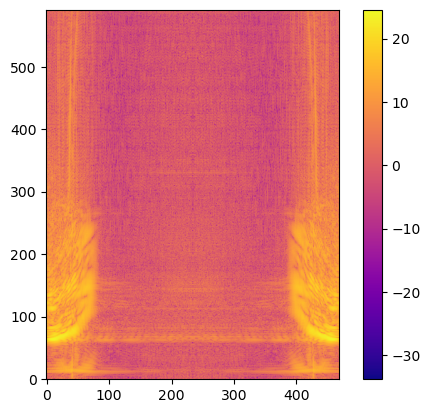

In [276]:
# # fk spectra, not working yet
# image = output_data[137,:,:,chan]
# # fftshift = np.fft.fftshift(image)
# fft1 = np.fft.fft(image, axis=0)
# fft2 = np.fft.fft(fft1, axis=1)
# fft2shift = np.fft.ifft(fft2) # swaps all half spaces
# plt.imshow(10*np.log10(np.abs(fft2shift)).T, origin = 'lower', cmap='plasma')
# plt.colorbar()
# plt.show()

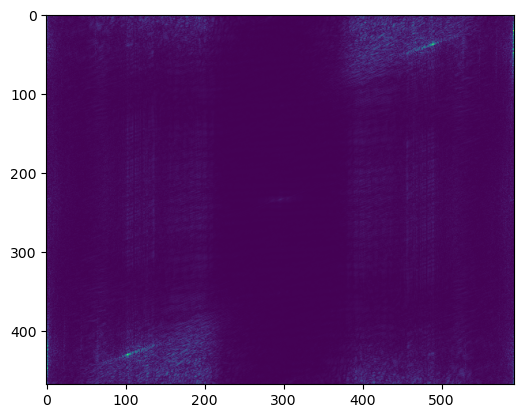

In [261]:
# test = np.fft.fft(image, axis=0)
# test = np.fft.fft(test, axis=1)
# plt.imshow(abs(test))
# plt.show()

In [49]:
# specify a list of tuples defining how each load version was normalized, in order
scale_ranges = [[-1,1]]

In [67]:
# plot predictions, difference panels, power spectra, fk spectra. power spectra and fk spectra not quite working in this cell.
# Just use for predictions/differences
""" updated 5.*"""
plot_pred = 1
plot_ps = 0
plot_fk = 0
gains = [1]

# from mpl_toolkits.axes_grid1 import make_axes_locatable

# model_idx = 1
# type_tag = 'Clean'
# epoch_selection = 0
# gain = 0.2 # 0.2

sample_interval = 2*10**-3
        
idx_end = 137
inline_idx = 0
chan = 0
# nil0 = 0


for model_idx in [0,1,2]:
    for type_tag in ['Clean', 'Diff']:
        for gain in gains:
            for epoch_selection in [0,1]:
                if epochs_tag == '10_1001_10':
                    if epoch_selection == 0:
                        epoch_plot_tag = '10-100'
                    elif epoch_selection == 1:
                        epoch_plot_tag = '100-1000' 
                elif epochs_tag == '1_51_1':
                    if epoch_selection == 0: # no second option for the ealy epochs
                         epoch_plot_tag = '1-10'
                    elif epoch_selection == 1:
                        break
                        
                diff_gain = 10
                cbar_scale = 1/gain
                diff_cbar_scale = 1/diff_gain

                load_version = load_versions[model_idx] #         
                description = descriptions[model_idx]
                # i = np.where(np.array(load_versions)==load_version)[0][0]
                print(load_versions[model_idx])
                print(descriptions[model_idx])
                model_clean_images = all_clean_images[model_idx]
                model_differences = all_differences[model_idx]
                scale_range = scale_ranges[model_idx]
                
                fig_name = f'./Predictions/Unet_{load_version}_il{idx_end+nil0+inline_idx}_gain{gain}_predict_{epoch_plot_tag}_{type_tag}.png'
                print(fig_name)

                fig = plt.subplots(figsize=(3.6, 7.2))
                plt.imshow(y_tests[model_idx][inline_idx,:,:,chan].T, vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale, aspect='auto')
                # plt.title(f'Line {idx_end+nil0+inline_idx}')
                plt.title(f'Raw Data')
                plt.axis('tight')
                plt.gray()
                # plt.savefig(f'DeepRift_il{idx_end+nil0+inline_idx}_gain{gain}.png')
                # plt.savefig(f'swelldat_il{idx_end+nil0+inline_idx}_output_gain{gain}.png')

                                       # gridspec_kw={'width_ratios': np.ones((3,3))}

                if type_tag == 'Clean':
                    if epoch_selection == 0:
                        images = model_clean_images
                        epoch_titles = epochs
                    elif epoch_selection == 1:
                        images = model_clean_images[9:109:10] 
                        epoch_titles = epochs[9:109:10] 
                if type_tag == 'Diff':
                    if epoch_selection == 0:
                        images = model_differences
                        epoch_titles = epochs
                    elif epoch_selection == 1:
                        images = model_differences[9:109:10] 
                        epoch_titles = epochs[9:109:10] 
                    # [9:109:10]    # Change based on epochs to select
                # gain = diff_gain

                # plt.rc('font', size=16)
                print(images.shape)
                
                if plot_pred:
                    fig, axes = plt.subplots(2, 5, figsize=(18, 9))
                    axes = axes.flatten()

                    range_ends = [0,9]
                    plotnum = 1
                    for i in range(range_ends[0],range_ends[1]+1):

                        plt.subplot(2,5,plotnum)
                        plt.imshow(images[i][inline_idx,:,:,chan].T,
                                   # cmap='RdYlBu', 
                                   vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale
                                  )
                        plt.gray()
                        plt.colorbar()
                        plt.axis('tight')
                        # plt.title(epochs[9:109:10][i])
                        plt.title(epoch_titles[i])
                        plotnum+=1
                    # plt.suptitle(f'{load_versions[i]}')

                    # plt.suptitle(f'Mo DeepRift {type_tag} Line {idx_end+nil0+inline_idx}, gain: {gain}\n{load_version}: {description}', y=1)
                    # plt.suptitle(f'Stripedat {type_tag}\n{load_version}\n{description}\ngain: {gain}', y=1)
                    plt.suptitle(f'Stripedat DIP Predicted {type_tag}\n{description}\ngain: {gain}', y=1)

                    fig.tight_layout()
                    # plt.savefig(f'Unet_{load_version}_il{idx_end+nil0+inline_idx}_gain{gain}_img{range_ends[0]}_{range_ends[1]}.png')
                    plt.savefig(fig_name)
                    plt.show()

                    plt.rcParams.update(plt.rcParamsDefault)

                
                if gain ==1:
                    """ Power Spectra """
#                     if plot_ps:
#                         fig, axes = plt.subplots(2, 5, figsize=(18, 9))
#                         axes = axes.flatten()

#                         range_ends = [0,9]
#                         plotnum = 1
#                         for i in range(range_ends[0],range_ends[1]+1):
#                             plt.subplot(2,5,plotnum)
#                             image = images[i][inline_idx,:,:,chan]
#                             ps = np.average(np.abs(np.fft.fft(image)), axis=0)
#                             freqs = np.fft.fftfreq(ps.size, sample_interval)
#                             idx = np.argsort(freqs)
#                             idx = idx[len(idx)//2:]
#                             plt.plot(freqs[idx], ps[idx])
#                             plt.axis('tight')
#                             plt.xlim([0,50])
#                             # plt.title(epochs[9:109:10][i])
#                             plt.title(epoch_titles[i])
#                             plotnum+=1
#                         # plt.suptitle(f'{load_versions[i]}')

#                         # plt.suptitle(f'Mo DeepRift {type_tag} Line {idx_end+nil0+inline_idx}, gain: {gain}\n{load_version}: {description}', y=1)
#                         plt.suptitle(f'Stripedat {type_tag} Power Spectra\n{load_version}\n{description}', y=1)

#                         fig.tight_layout()
#                         # plt.savefig(f'Unet_{load_version}_il{idx_end+nil0+inline_idx}_gain{gain}_img{range_ends[0]}_{range_ends[1]}.png')
#                         ps_fig_name = f'./Predictions/Unet_{load_version}_il{idx_end+nil0+inline_idx}_predict_{epoch_plot_tag}_{type_tag}_ps.png'
#                         # plt.savefig(ps_fig_name)
#                         plt.show()

#                         plt.rcParams.update(plt.rcParamsDefault)

                    """ FK Spectra """
                    if plot_fk:
                        fig, axes = plt.subplots(2, 5, figsize=(18, 9))
                        axes = axes.flatten()

                        range_ends = [0,9]
                        plotnum = 1
                        for i in range(range_ends[0],range_ends[1]+1):
                            plt.subplot(2,5,plotnum)
                            image = images[i][inline_idx,:,:,chan]
                            plt.imshow(np.abs(np.fft.fft2(image)).T)
                            plt.title(epoch_titles[i])
                            plotnum+=1
                        # plt.suptitle(f'{load_versions[i]}')

                        # plt.suptitle(f'Mo DeepRift {type_tag} Line {idx_end+nil0+inline_idx}, gain: {gain}\n{load_version}: {description}', y=1)
                        plt.suptitle(f'Stripedat {type_tag} FK\n{load_version}\n{description}', y=1)

                        fig.tight_layout()
                        # plt.savefig(f'Unet_{load_version}_il{idx_end+nil0+inline_idx}_gain{gain}_img{range_ends[0]}_{range_ends[1]}.png')
                        ps_fig_name = f'./Predictions/Unet_{load_version}_il{idx_end+nil0+inline_idx}_predict_{epoch_plot_tag}_{type_tag}_fk.png'
                        plt.savefig(ps_fig_name)
                        plt.show()

                        plt.rcParams.update(plt.rcParamsDefault)
            
                else:
                    pass



6.0.il0-137
6.0 DIP L2, bottom skip
./Predictions/Unet_6.0.il0-137_il137_gain1_predict_1-10_Clean.png
(50, 1, 468, 592, 1)
6.0.il0-137
6.0 DIP L2, bottom skip
./Predictions/Unet_6.0.il0-137_il137_gain1_predict_1-10_Diff.png
(50, 1, 468, 592, 1)


IndexError: list index out of range

In [52]:
# define epochs at which to evaluate power spectra
ps_epochs_slice = slice(4,109,5)
# ps_epochs_slice = slice(0,109,1)
epochs[ps_epochs_slice]


array([  50,  100,  150,  200,  250,  300,  350,  400,  450,  500,  550,
        600,  650,  700,  750,  800,  850,  900,  950, 1000])

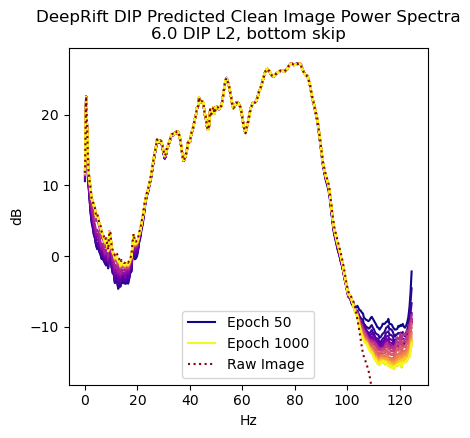

In [56]:
# plot power spectra of later epochs
""" Power Spectra """             '''for 10-1000 the sample_interval variable will work later work I hard coded freq/4 as instructed'''
# ps_epochs_slice
inline_idx = 0
chan=0
sample_interval = 4000/1000000
dB_bool = True
type_tag = 'Clean'
detrend_mean = 1


epochs_cmap = plt.cm.plasma(np.linspace(0,1,len(epochs[ps_epochs_slice])))

nrows = 1

fig, axes = plt.subplots(nrows, len(load_versions), figsize=(12, 8*nrows))
# axes = axes.flatten()
for model_idx in range(len(load_versions)):
    
    load_version = load_versions[model_idx] #         
    description = descriptions[model_idx]
    model_clean_images = all_clean_images[model_idx]
    model_differences = all_differences[model_idx]
    scale_range = scale_ranges[model_idx]
    
    """plot power spectrum for epoch"""
    plt.subplot(2,3,model_idx+1)
    if type_tag == 'Clean':
        images = model_clean_images[ps_epochs_slice][:,inline_idx,:,:,chan]
    elif type_tag == 'Diff':
        images = model_differences[ps_epochs_slice][:,inline_idx,:,:,chan]
    if detrend_mean:
        img_avgs = np.mean(images, axis=(1,2))
        for epoch_idx in range(len(images)):
            images[epoch_idx] = images[epoch_idx] - img_avgs[epoch_idx]

    for epoch_idx in range(images.shape[0]):
        image = images[epoch_idx,:,:]
        ps = np.average(np.abs(np.fft.fft(image)), axis=0)
        freqs = np.fft.fftfreq(ps.size, sample_interval)
        # freqs = freqs/4
        idx = np.argsort(freqs)
        idx = idx[len(idx)//2:]
        if epoch_idx == 0 or epoch_idx == images.shape[0]-1:      # just put ends of color gradient on legend
            condlabel = f'Epoch {epochs[ps_epochs_slice][epoch_idx]}'
        else:
            condlabel = None
        if dB_bool == True:
            plt.plot(freqs[idx], 20*np.log10(ps[idx]), color = epochs_cmap[epoch_idx], label = condlabel)
            plt.ylabel('dB')
            power_amp_tag = 'Power'
        else:
            plt.plot(freqs[idx], ps[idx], color = epochs_cmap[epoch_idx], label = condlabel)
            plt.ylabel('Amplitude')
            power_amp_tag = 'Amplitude'
        plt.xlabel('Hz')
        plt.axis('tight')
        # plt.xlim([0,50])
        plt.title(f'DeepRift DIP Predicted {type_tag} Image {power_amp_tag} Spectra\n{description}')
        # plt.suptitle(f'{load_versions[i]}')
        
    """plot input/output power spectra"""
    input_image = x_test[inline_idx, :, :, chan]
    output_image = y_test[inline_idx, :, :, chan]
    diff_image = output_image-input_image
    input_ps = np.average(np.abs(np.fft.fft(input_image)), axis=0)
    output_ps = np.average(np.abs(np.fft.fft(output_image)), axis=0)
    diff_ps = np.average(np.abs(np.fft.fft(diff_image)), axis=0)
    if dB_bool == True and type_tag == 'Clean':
        # plt.plot(freqs[idx], 20*np.log10(input_ps[idx]), color = 'darkblue', linestyle = 'dotted', label = 'Input Image')
        plt.plot(freqs[idx], 20*np.log10(output_ps[idx]), color = 'darkred', linestyle = 'dotted', label = 'Raw Image')
    elif dB_bool == False and type_tag == 'Clean':
        # plt.plot(freqs[idx], input_ps[idx], color = 'darkblue', linestyle = 'dotted', label = 'Input Image')
        plt.plot(freqs[idx], output_ps[idx], color = 'darkred', linestyle = 'dotted', label = 'Raw Image')
    elif dB_bool == True and type_tag == 'Diff':
        # plt.plot(freqs[idx], 20*np.log10(input_ps[idx]), color = 'darkblue', linestyle = 'dotted', label = 'Input Image')
        plt.plot(freqs[idx], 20*np.log10(output_ps[idx]), color = 'darkred', linestyle = 'dotted', label = 'Raw Image')
        plt.plot(freqs[idx], 20*np.log10(diff_ps[idx]), color = 'grey', linestyle = 'dotted', label = 'True difference')
    elif dB_bool == False and type_tag == 'Diff':
        # plt.plot(freqs[idx], input_ps[idx], color = 'darkblue', linestyle = 'dotted', label = 'Input Image')
        plt.plot(freqs[idx], output_ps[idx], color = 'darkred', linestyle = 'dotted', label = 'Raw Image')
        plt.plot(freqs[idx], diff_ps[idx], color = 'grey', linestyle = 'dotted', label = 'True difference')    
    plt.legend(loc='lower center')
    # plt.suptitle(f'DeepRift DIP Predicted {type_tag} Image {power_amp_tag} Spectra', y=1)

fig.tight_layout()
# ps_fig_name = f'./Predictions/Unet_{load_version}_il{idx_end+nil0+inline_idx}_predict_{epoch_plot_tag}_{type_tag}_ps.png'
# plt.savefig(ps_fig_name)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

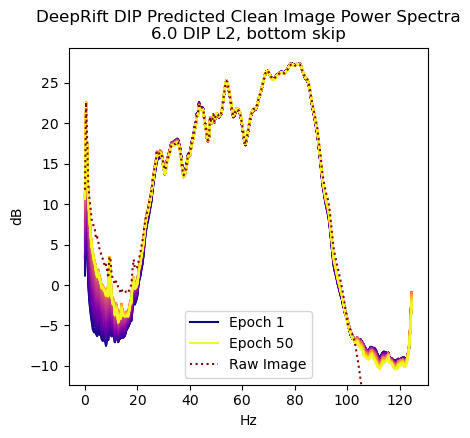

In [62]:
# plot power spectra of early epochs
""" Power Spectra """             '''for 1-10 the sample_interval variable will work later work I hard coded freq/4 as instructed'''
# ps_epochs_slice
inline_idx = 0
chan=0
sample_interval = 4000/1000000
dB_bool = True
type_tag = 'Clean'
detrend_mean = 1


epochs_cmap = plt.cm.plasma(np.linspace(0,1,len(epochs[:])))

nrows = 1

fig, axes = plt.subplots(nrows, len(load_versions), figsize=(12, 8*nrows))
# axes = axes.flatten()
for model_idx in range(len(load_versions)):
    
    load_version = load_versions[model_idx] #         
    description = descriptions[model_idx]
    model_clean_images = all_clean_images[model_idx]
    model_differences = all_differences[model_idx]
    scale_range = scale_ranges[model_idx]
    
    """plot power spectrum for epoch"""
    plt.subplot(2,3,model_idx+1)
    if type_tag == 'Clean':
        images = model_clean_images[:][:,inline_idx,:,:,chan]
    elif type_tag == 'Diff':
        images = model_differences[:][:,inline_idx,:,:,chan]
    if detrend_mean:
        img_avgs = np.mean(images, axis=(1,2))
        for epoch_idx in range(len(images)):
            images[epoch_idx] = images[epoch_idx] - img_avgs[epoch_idx]

    for epoch_idx in range(images.shape[0]):
        image = images[epoch_idx,:,:]
        ps = np.average(np.abs(np.fft.fft(image)), axis=0)
        freqs = np.fft.fftfreq(ps.size, sample_interval)
        # freqs = freqs/4
        idx = np.argsort(freqs)
        idx = idx[len(idx)//2:]
        if epoch_idx == 0 or epoch_idx == images.shape[0]-1:      # just put ends of color gradient on legend
            condlabel = f'Epoch {epochs[:][epoch_idx]}'
        else:
            condlabel = None
        if dB_bool == True:
            plt.plot(freqs[idx], 20*np.log10(ps[idx]), color = epochs_cmap[epoch_idx], label = condlabel)
            plt.ylabel('dB')
            power_amp_tag = 'Power'
        else:
            plt.plot(freqs[idx], ps[idx], color = epochs_cmap[epoch_idx], label = condlabel)
            plt.ylabel('Amplitude')
            power_amp_tag = 'Amplitude'
        plt.xlabel('Hz')
        plt.axis('tight')
        # plt.xlim([0,50])
        plt.title(f'DeepRift DIP Predicted {type_tag} Image {power_amp_tag} Spectra\n{description}')
        # plt.suptitle(f'{load_versions[i]}')
        
    """plot input/output power spectra"""
    input_image = x_test[inline_idx, :, :, chan]
    output_image = y_test[inline_idx, :, :, chan]
    diff_image = output_image-input_image
    input_ps = np.average(np.abs(np.fft.fft(input_image)), axis=0)
    output_ps = np.average(np.abs(np.fft.fft(output_image)), axis=0)
    diff_ps = np.average(np.abs(np.fft.fft(diff_image)), axis=0)
    if dB_bool == True and type_tag == 'Clean':
        # plt.plot(freqs[idx], 20*np.log10(input_ps[idx]), color = 'darkblue', linestyle = 'dotted', label = 'Input Image')
        plt.plot(freqs[idx], 20*np.log10(output_ps[idx]), color = 'darkred', linestyle = 'dotted', label = 'Raw Image')
    elif dB_bool == False and type_tag == 'Clean':
        # plt.plot(freqs[idx], input_ps[idx], color = 'darkblue', linestyle = 'dotted', label = 'Input Image')
        plt.plot(freqs[idx], output_ps[idx], color = 'darkred', linestyle = 'dotted', label = 'Raw Image')
    elif dB_bool == True and type_tag == 'Diff':
        # plt.plot(freqs[idx], 20*np.log10(input_ps[idx]), color = 'darkblue', linestyle = 'dotted', label = 'Input Image')
        plt.plot(freqs[idx], 20*np.log10(output_ps[idx]), color = 'darkred', linestyle = 'dotted', label = 'Raw Image')
        plt.plot(freqs[idx], 20*np.log10(diff_ps[idx]), color = 'grey', linestyle = 'dotted', label = 'True difference')
    elif dB_bool == False and type_tag == 'Diff':
        # plt.plot(freqs[idx], input_ps[idx], color = 'darkblue', linestyle = 'dotted', label = 'Input Image')
        plt.plot(freqs[idx], output_ps[idx], color = 'darkred', linestyle = 'dotted', label = 'Raw Image')
        plt.plot(freqs[idx], diff_ps[idx], color = 'grey', linestyle = 'dotted', label = 'True difference')    
    plt.legend(loc='lower center')
    # plt.suptitle(f'DeepRift DIP Predicted {type_tag} Image {power_amp_tag} Spectra', y=1)

fig.tight_layout()
# ps_fig_name = f'./Predictions/Unet_{load_version}_il{idx_end+nil0+inline_idx}_predict_{epoch_plot_tag}_{type_tag}_ps.png'
# plt.savefig(ps_fig_name)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

In [48]:
model_clean_images.shape

(100, 1, 468, 592, 4)

In [57]:
model_differences.shape

(50, 1, 468, 592, 4)

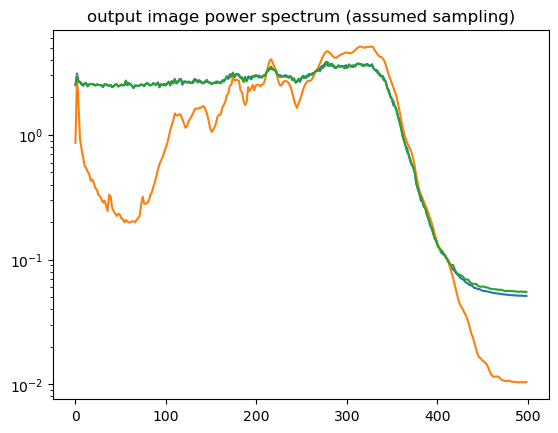

In [164]:
# # Some debugging/analysis stuff. Ignore
# # image = images[0][0,:,:,chan].T

# input_image = x_test[inline_idx, :, :, chan]
# output_image = y_test[inline_idx, :, :, chan]
# diff_image = output_image - input_image
# input_ps = np.average(np.abs(np.fft.fft(input_image)), axis=0)
# output_ps = np.average(np.abs(np.fft.fft(output_image)), axis=0)
# diff_ps = np.average(np.abs(np.fft.fft(diff_image)), axis=0)
# plt.plot(freqs[idx], input_ps[idx])
# plt.plot(freqs[idx], output_ps[idx])
# plt.plot(freqs[idx], diff_ps[idx])
# plt.yscale('log')
# plt.title('output image power spectrum (assumed sampling)')
# plt.show()

# # freqs = np.fft.fftfreq(

# Everything below this may be outdated

In [ ]:
chan = 0
nil0 = 0
gain = 4
diff_gain = 10
cbar_scale = 1/gain
diff_cbar_scale = 1/diff_gain
# inline_num = i_start_test+nil0+chan # leave for now, but will need to change when using multiple RGBA images / batches, chan handling will need to change
inline_num = 67
inline_num = inline_num - i_start_test

fig, ax = plt.subplots(3, 3, figsize=(18, 9),
                       # gridspec_kw={'width_ratios': np.ones((3,3))}
                      )
ax = ax.flatten()
# plt.rc('font', size=16)

for i in range(len(epochs)):
    ax[i].imshow(Clean_images_list[i][inline_num,:,:,chan].T, cmap='RdYlBu', vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale)
    ax[i].colorbar()

fig.tight_layout()
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


chan = 0
nil0 = 0
gain = 4
diff_gain = 10
cbar_scale = 1/gain
diff_cbar_scale = 1/diff_gain
# inline_num = i_start_test+nil0+chan # leave for now, but will need to change when using multiple RGBA images / batches, chan handling will need to change
inline_num = 67
inline_num = inline_num - i_start_test

fig, ax = plt.subplots(3, 3, figsize=(18, 9),
                       # gridspec_kw={'width_ratios': np.ones((3,3))}
                      )
ax = ax.flatten()


# plt.rc('font', size=16)

for i in range(len(epochs)):
    im = ax[i].imshow(Clean_images_list[i][inline_num,:,:,chan].T, cmap='RdYlBu', vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.axis('tight')

# fig.tight_layout()
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
plt.imshow(Clean_images_list[6][inline_num,:,:,chan].T, cmap='RdYlBu', vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale)
plt.colorbar()
plt.axis('tight')

In [ ]:
Clean_images_list[6].shape

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


chan = 0
nil0 = 0
gain = 4
diff_gain = 10
cbar_scale = 1/gain
diff_cbar_scale = 1/diff_gain
# inline_num = i_start_test+nil0+chan # leave for now, but will need to change when using multiple RGBA images / batches, chan handling will need to change
inline_num = 67
inline_num = inline_num - i_start_test

fig, ax = plt.subplots(3, 3, figsize=(18, 9),
                       # gridspec_kw={'width_ratios': np.ones((3,3))}
                      )
ax = ax.flatten()

# plt.rc('font', size=16)

for i in range(len(epochs)):
    print(i)
    plt.subplot(3,3,i+1)
    plt.imshow(Clean_images_list[i][inline_num,:,:,chan].T, cmap='RdYlBu', vmin=scale_range[0]*cbar_scale, vmax=scale_range[1]*cbar_scale)
    plt.colorbar()
    plt.axis('tight')

# fig.tight_layout()
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
chan = 0
inline_num = i_start_test+nil0+chan # leave for now, but will need to change when using multiple RGBA images / batches, chan handling will need to change

for i in range(len(epochs)):
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 8), gridspec_kw={'width_ratios': [1,1,1]})
    plt.rc('font', size=16)

    plt.subplot(1,3,1)
    plt.imshow(x_test[0,:,:,chan].T, cmap='RdYlBu', extent=(nxl0, nxl1, nt1, nt0), vmin=scale_range[0], vmax=scale_range[1])
    plt.title(r'Kerry3D')
    plt.axis('tight')
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.imshow(Clean_images_list[i][0,:,:,chan].T, cmap='RdYlBu', extent=(nxl0, nxl1, nt1, nt0),
               vmin=scale_range[0], vmax=scale_range[1]
              )
    plt.title(r'Denoised')
    plt.axis('tight')
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.imshow(Difference_list[i][0,:,:,chan].T, cmap='RdYlBu', extent=(nxl0, nxl1, nt1, nt0),
    #            vmin=scale_range[0], vmax=scale_range[1]
#                vmin=-0.03, vmax=0.03
               vmin=-0.06, vmax=0.06
              )
    plt.title('Noise Removed')
    plt.axis('tight')
    plt.colorbar()


    plt.suptitle(f'{load_version} Inline {inline_num} Epoch {epochs[i]}')
    fig.tight_layout()
    plt.gray()

    plt.savefig(f'Unet_{load_version}_3panel_chan{chan}_epoch_{epochs[i]}.png')
    plt.rcParams.update(plt.rcParamsDefault)

# Train the loaded model

### Prep Checkpoints

In [ ]:
import tensorflow as tf
import os

version = 'test'

pathstart = './Logs/checkpoints_{}/'.format(version)
pathend = 'ckpt-{epoch:02d}.hdf5'
ckpt_filepath = pathstart + pathend

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = ckpt_filepath,
    # save_weights_only=False,
    save_weights_only=True,
    monitor=('loss'),
    mode='max',
    save_freq='epoch',
    verbose=1,
    save_best_only=False, # want to save full model every x epochs to print image
)

tensor_board_callback = tf.keras.callbacks.TensorBoard(log_dir=f'./Logs/TBlog_{version}', write_graph=True, write_images=True)
csvlogger_callback = tf.keras.callbacks.CSVLogger(f'./Logs/csvlog_{version}.csv', separator=',', append=False)
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Compile and Train

In [ ]:
loaded_model.compile(optimizer='adam', loss='mse') # loss function

In [ ]:
tf.keras.utils.plot_model(loaded_model, to_file= f'./{version}_arch.png', show_shapes=True, show_layer_names=True)

start_time = time.time()
try:
    history=loaded_model.fit(x_train, x_train,
                    epochs=1000,
#                 epochs=5000,
#                 batch_size=2,        # c.f. discussion on batch size
                    batch_size=1,
                    shuffle=True,        # shuffles whole dataset, not within batches
#                 shuffle=False,
                    validation_data=(x_train, x_train),   # What goes into the loss function each epoch.
                    callbacks=[
                        model_checkpoint_callback,
                        tensor_board_callback,
                        csvlogger_callback,
#                     early_stopping_callback,
                    ])
    
except KeyboardInterrupt:
    tf.keras.backend.clear_session()

end_time = time.time()
elapsed_time = end_time-start_time
print(f'Elapsed time: {elapsed_time}')

# Visualize the loss function

In [ ]:
print(history.history.keys())

# summarize history for loss
fig, axes = plt.subplots(1,2, figsize=(15,6))
ax = axes[0]
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
ax = axes[1]
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_yscale('log')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')
plt.suptitle(f'Unet_{load_version}_loss')

# plt.savefig(f'Unet_{load_version}_loss_RR.png')
plt.show()

# Save model

In [ ]:
from keras.models import model_from_json
Unet1_json = loaded_model.to_json()
with open(f"Unet_{version}.1.json", "w") as json_file:
    json_file.write(Unet1_json)
# serialize weights to HDF5
loaded_model.save_weights(f"Unet_{version}.1.h5")
print("Saved model to disk")

# Test Model

In [ ]:
noise_factor = 0 # BE MINDFUL OF WHAT THIS NUMBER MEANS GIVEN THE NORMALIZATION
noise_stdev = 1.0
# x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=noise_stdev, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.5, scale=noise_stdev, size=x_test.shape)

print(np.shape(x_train_noisy))
print(np.shape(x_test_noisy))

In [ ]:
Clean_images= loaded_model.predict(x_test)
Clean_images=np.reshape(Clean_images,(4,732,1252))
# Clean_images=np.reshape(Clean_images,(4,732,1252))
Clean_images.shape

In [ ]:
n = 4
plt.figure(figsize=(20, 20))
for i in range(1, 4):
    ax = plt.subplot(1, n, i)
    #Clean_images=Clean_images.reshape(4,732, 1252)
    plt.imshow(Clean_images[i].T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
x_test=np.reshape(x_test, (4,732,1252))
x_test_noisy=np.reshape(x_test_noisy, (4,732,1252))

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(1,3,1)
plt.imshow(x_test[3].T)

plt.subplot(1,3,2)
plt.imshow(x_test_noisy[3].T)

plt.subplot(1,3,3)
plt.imshow(Clean_images[3].T)


# Visualize the removed noise

Needs more training. clear geology removed.

In [ ]:
plt.figure(figsize=(20, 20))
Difference= x_test_noisy[3] - Clean_images[3]
plt.imshow(Difference.T)

In [ ]:
plt.figure(figsize=(8, 12))
Difference= x_test[0] - Clean_images[0]
plt.imshow(Difference.T, cmap='RdYlBu', extent=(nxl0, nxl1, nt1, nt0), vmin=-0.02, vmax=0.02)
plt.colorbar()
plt.axis('tight')
plt.title('Noise Removed')
# plt.savefig(f'Unet_{version}_noise.png')